<a href="https://colab.research.google.com/github/iasolb/ECON3916-Statistics-MachineLearning/blob/main/class2/Class2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2: Deflating History with FRED


In [ ]:
# !pip install fredapi

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred
fred = Fred(api_key='8de61e4a49d7c25c75aca7eaae2eafa5')

Work


In [ ]:
# 1. Fetch the data series
print("Fetching data from FRED...")
wages = fred.get_series('AHETPI')
cpi = fred.get_series('CPIAUCSL')

# 2. Combine into a DataFrame
df = pd.DataFrame({'Nominal_Wage': wages, 'CPI': cpi})

# 3. Drop missing values (The wage data starts later than CPI data)
df = df.dropna()

# Inspect the raw data
print(df.head())
print(df.tail())

Fetching data from FRED...
            Nominal_Wage    CPI
1964-01-01          2.50  30.94
1964-02-01          2.50  30.91
1964-03-01          2.51  30.94
1964-04-01          2.52  30.95
1964-05-01          2.52  30.98
            Nominal_Wage      CPI
2025-06-01         31.26  321.500
2025-07-01         31.35  322.132
2025-08-01         31.45  323.364
2025-09-01         31.52  324.368
2025-11-01         31.73  325.031


In [ ]:
def get_real_wage(nominal_col, cpi_col):
    """
    Takes a nominal column and a CPI column.
    Returns a new column adjusted for inflation (Real Dollars).
    """
    # 1. Get the CPI of the most recent date (Today's Prices)
    # .iloc[-1] grabs the very last row in the data
    cpi_today = cpi_col.iloc[-1]

    # 2. The Formula: (Nominal / Old_CPI) * CPI_Today
    real_col = (nominal_col / cpi_col) * cpi_today

    return real_col

# Apply the function to create a new column
# We feed the "Machine" our two columns:
df['Real_Wage'] = get_real_wage(df['Nominal_Wage'], df['CPI'])

# Check the result - Notice how Real Wages are different from Nominal!
print(df.tail())

            Nominal_Wage      CPI  Real_Wage
2025-06-01         31.26  321.500  31.603325
2025-07-01         31.35  322.132  31.632132
2025-08-01         31.45  323.364  31.612130
2025-09-01         31.52  324.368  31.584426
2025-11-01         31.73  325.031  31.730000


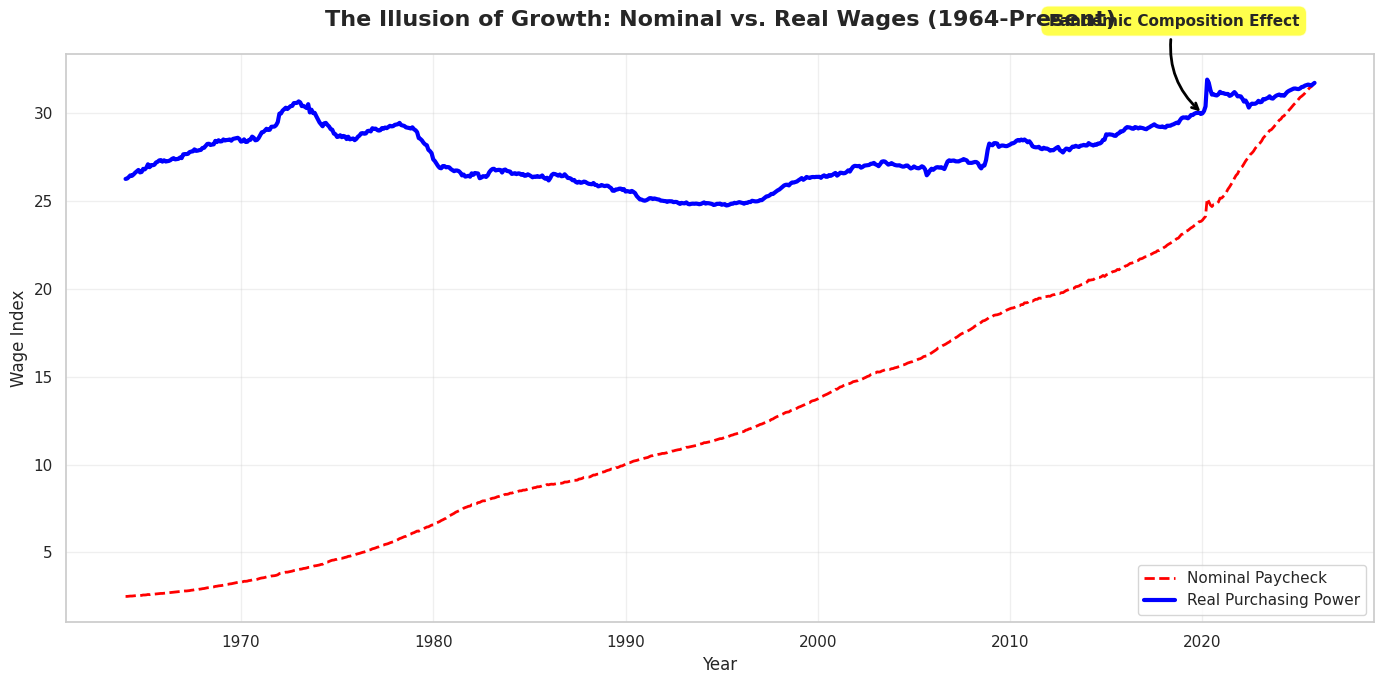

In [ ]:
import seaborn as sns

# Set the style
sns.set_theme(style="whitegrid")

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 7))

# Plot both wage series
ax.plot(df.index, df['Nominal_Wage'],
        color='red',
        linestyle='--',
        linewidth=2,
        label='Nominal Paycheck')

ax.plot(df.index, df['Real_Wage'],
        color='blue',
        linewidth=3,
        label='Real Purchasing Power')

# Add title and labels
ax.set_title('The Illusion of Growth: Nominal vs. Real Wages (1964-Present)',
             fontsize=16,
             fontweight='bold',
             pad=20)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Wage Index', fontsize=12)

# Add legend
ax.legend(loc='best', fontsize=11, frameon=True)

# Add annotation for 2020 pandemic effect
# Find the approximate location of the 2020 spike
pandemic_date = pd.Timestamp('2020-01-01')
if pandemic_date in df.index:
    pandemic_value = df.loc[pandemic_date, 'Real_Wage']
else:
    # Find closest date to 2020
    closest_idx = df.index.get_indexer([pandemic_date], method='nearest')[0]
    pandemic_date = df.index[closest_idx]
    pandemic_value = df.loc[pandemic_date, 'Real_Wage']

ax.annotate('Pandemic Composition Effect',
            xy=(pandemic_date, pandemic_value),
            xytext=(pandemic_date - pd.DateOffset(years=8), pandemic_value + 5),
            arrowprops=dict(arrowstyle='->',
                          connectionstyle='arc3,rad=0.3',
                          color='black',
                          lw=2),
            fontsize=11,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5',
                     facecolor='yellow',
                     alpha=0.7))

# Improve grid appearance
ax.grid(True, alpha=0.3)

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

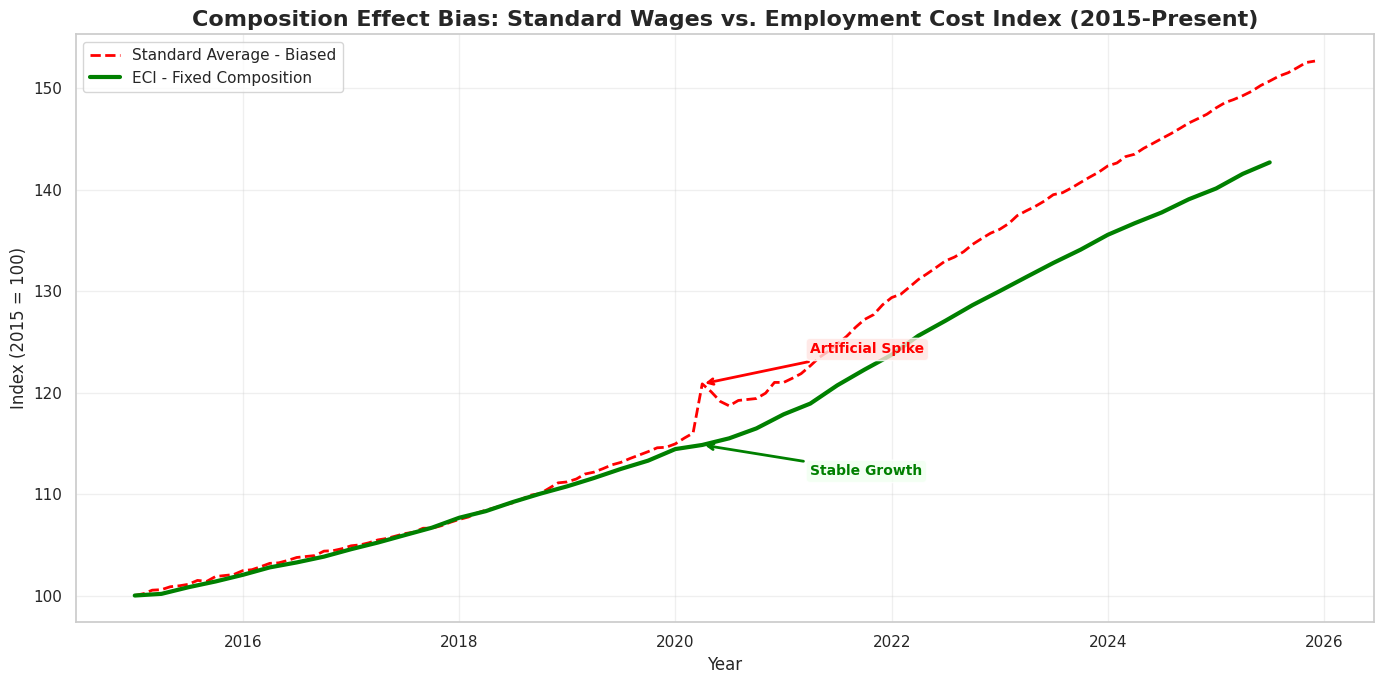

In [ ]:
eci = fred.get_series('ECIWAG')

# Filter both series to 2015 onwards
start_date = '2015-01-01'
wages_filtered = wages[wages.index >= start_date]
eci_filtered = eci[eci.index >= start_date]

# Rebase both series to 100 (first value = 100)
wages_rebased = (wages_filtered / wages_filtered.iloc[0]) * 100
eci_rebased = (eci_filtered / eci_filtered.iloc[0]) * 100

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot both series
ax.plot(wages_rebased.index, wages_rebased,
        color='red',
        linestyle='--',
        linewidth=2,
        label='Standard Average - Biased')

ax.plot(eci_rebased.index, eci_rebased,
        color='green',
        linewidth=3,
        label='ECI - Fixed Composition')

# Add title and labels
ax.set_title('Composition Effect Bias: Standard Wages vs. Employment Cost Index (2015-Present)',
             fontsize=16,
             fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Index (2015 = 100)', fontsize=12)

# Add legend
ax.legend(loc='best', fontsize=11)

# Add annotations for the 2020 divergence
pandemic_date = pd.Timestamp('2020-04-01')

# Find closest available dates
wages_idx = wages_rebased.index.get_indexer([pandemic_date], method='nearest')[0]
eci_idx = eci_rebased.index.get_indexer([pandemic_date], method='nearest')[0]

wages_date = wages_rebased.index[wages_idx]
eci_date = eci_rebased.index[eci_idx]

wages_value = wages_rebased.iloc[wages_idx]
eci_value = eci_rebased.iloc[eci_idx]

# Annotate the artificial spike in standard wages
ax.annotate('Artificial Spike',
            xy=(wages_date, wages_value),
            xytext=(wages_date + pd.DateOffset(years=1), wages_value + 3),
            arrowprops=dict(arrowstyle='->',
                          color='red',
                          lw=2),
            fontsize=10,
            fontweight='bold',
            color='red',
            bbox=dict(boxstyle='round',
                     facecolor='mistyrose',
                     alpha=0.8))

# Annotate the stable growth in ECI
ax.annotate('Stable Growth',
            xy=(eci_date, eci_value),
            xytext=(eci_date + pd.DateOffset(years=1), eci_value - 3),
            arrowprops=dict(arrowstyle='->',
                          color='green',
                          lw=2),
            fontsize=10,
            fontweight='bold',
            color='green',
            bbox=dict(boxstyle='round',
                     facecolor='honeydew',
                     alpha=0.8))

# Add grid
ax.grid(True, alpha=0.3)

# Tight layout
plt.tight_layout()

# Display the plot
plt.show()